# CROCUS 3D trajectory for wind sonde

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize

In [8]:
file_path = '2024-07-22_1427.raw_flight_history.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Strip any leading/trailing whitespace from column names
data.columns = data.columns.str.strip()

# Convert Latitude, Longitude, Altitude, Wind Speed, and Heading to numeric, forcing errors to NaN
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')
data['Altitude (m AGL)'] = pd.to_numeric(data['Altitude (m AGL)'], errors='coerce')
data['Speed (m/s)'] = pd.to_numeric(data['Speed (m/s)'], errors='coerce')
data['Heading (degrees)'] = pd.to_numeric(data['Heading (degrees)'], errors='coerce')

# Interpolate wind speed for rows with missing lat/lon
missing_lat_lon = data[(data['Latitude'].isna()) | (data['Longitude'].isna())]
non_missing_lat_lon = data.dropna(subset=['Latitude', 'Longitude'])


     Latitude  Longitude  Altitude (m AGL)  Speed (m/s)  Heading (degrees)
0   41.866345 -87.613980                 6         0.35               45.5
2   41.866300 -87.614017                 6         0.05              164.7
5   41.866300 -87.614073                12         3.25              242.8
8   41.866218 -87.614185                19         4.60              231.4
11  41.866142 -87.614313                24         4.10              236.4


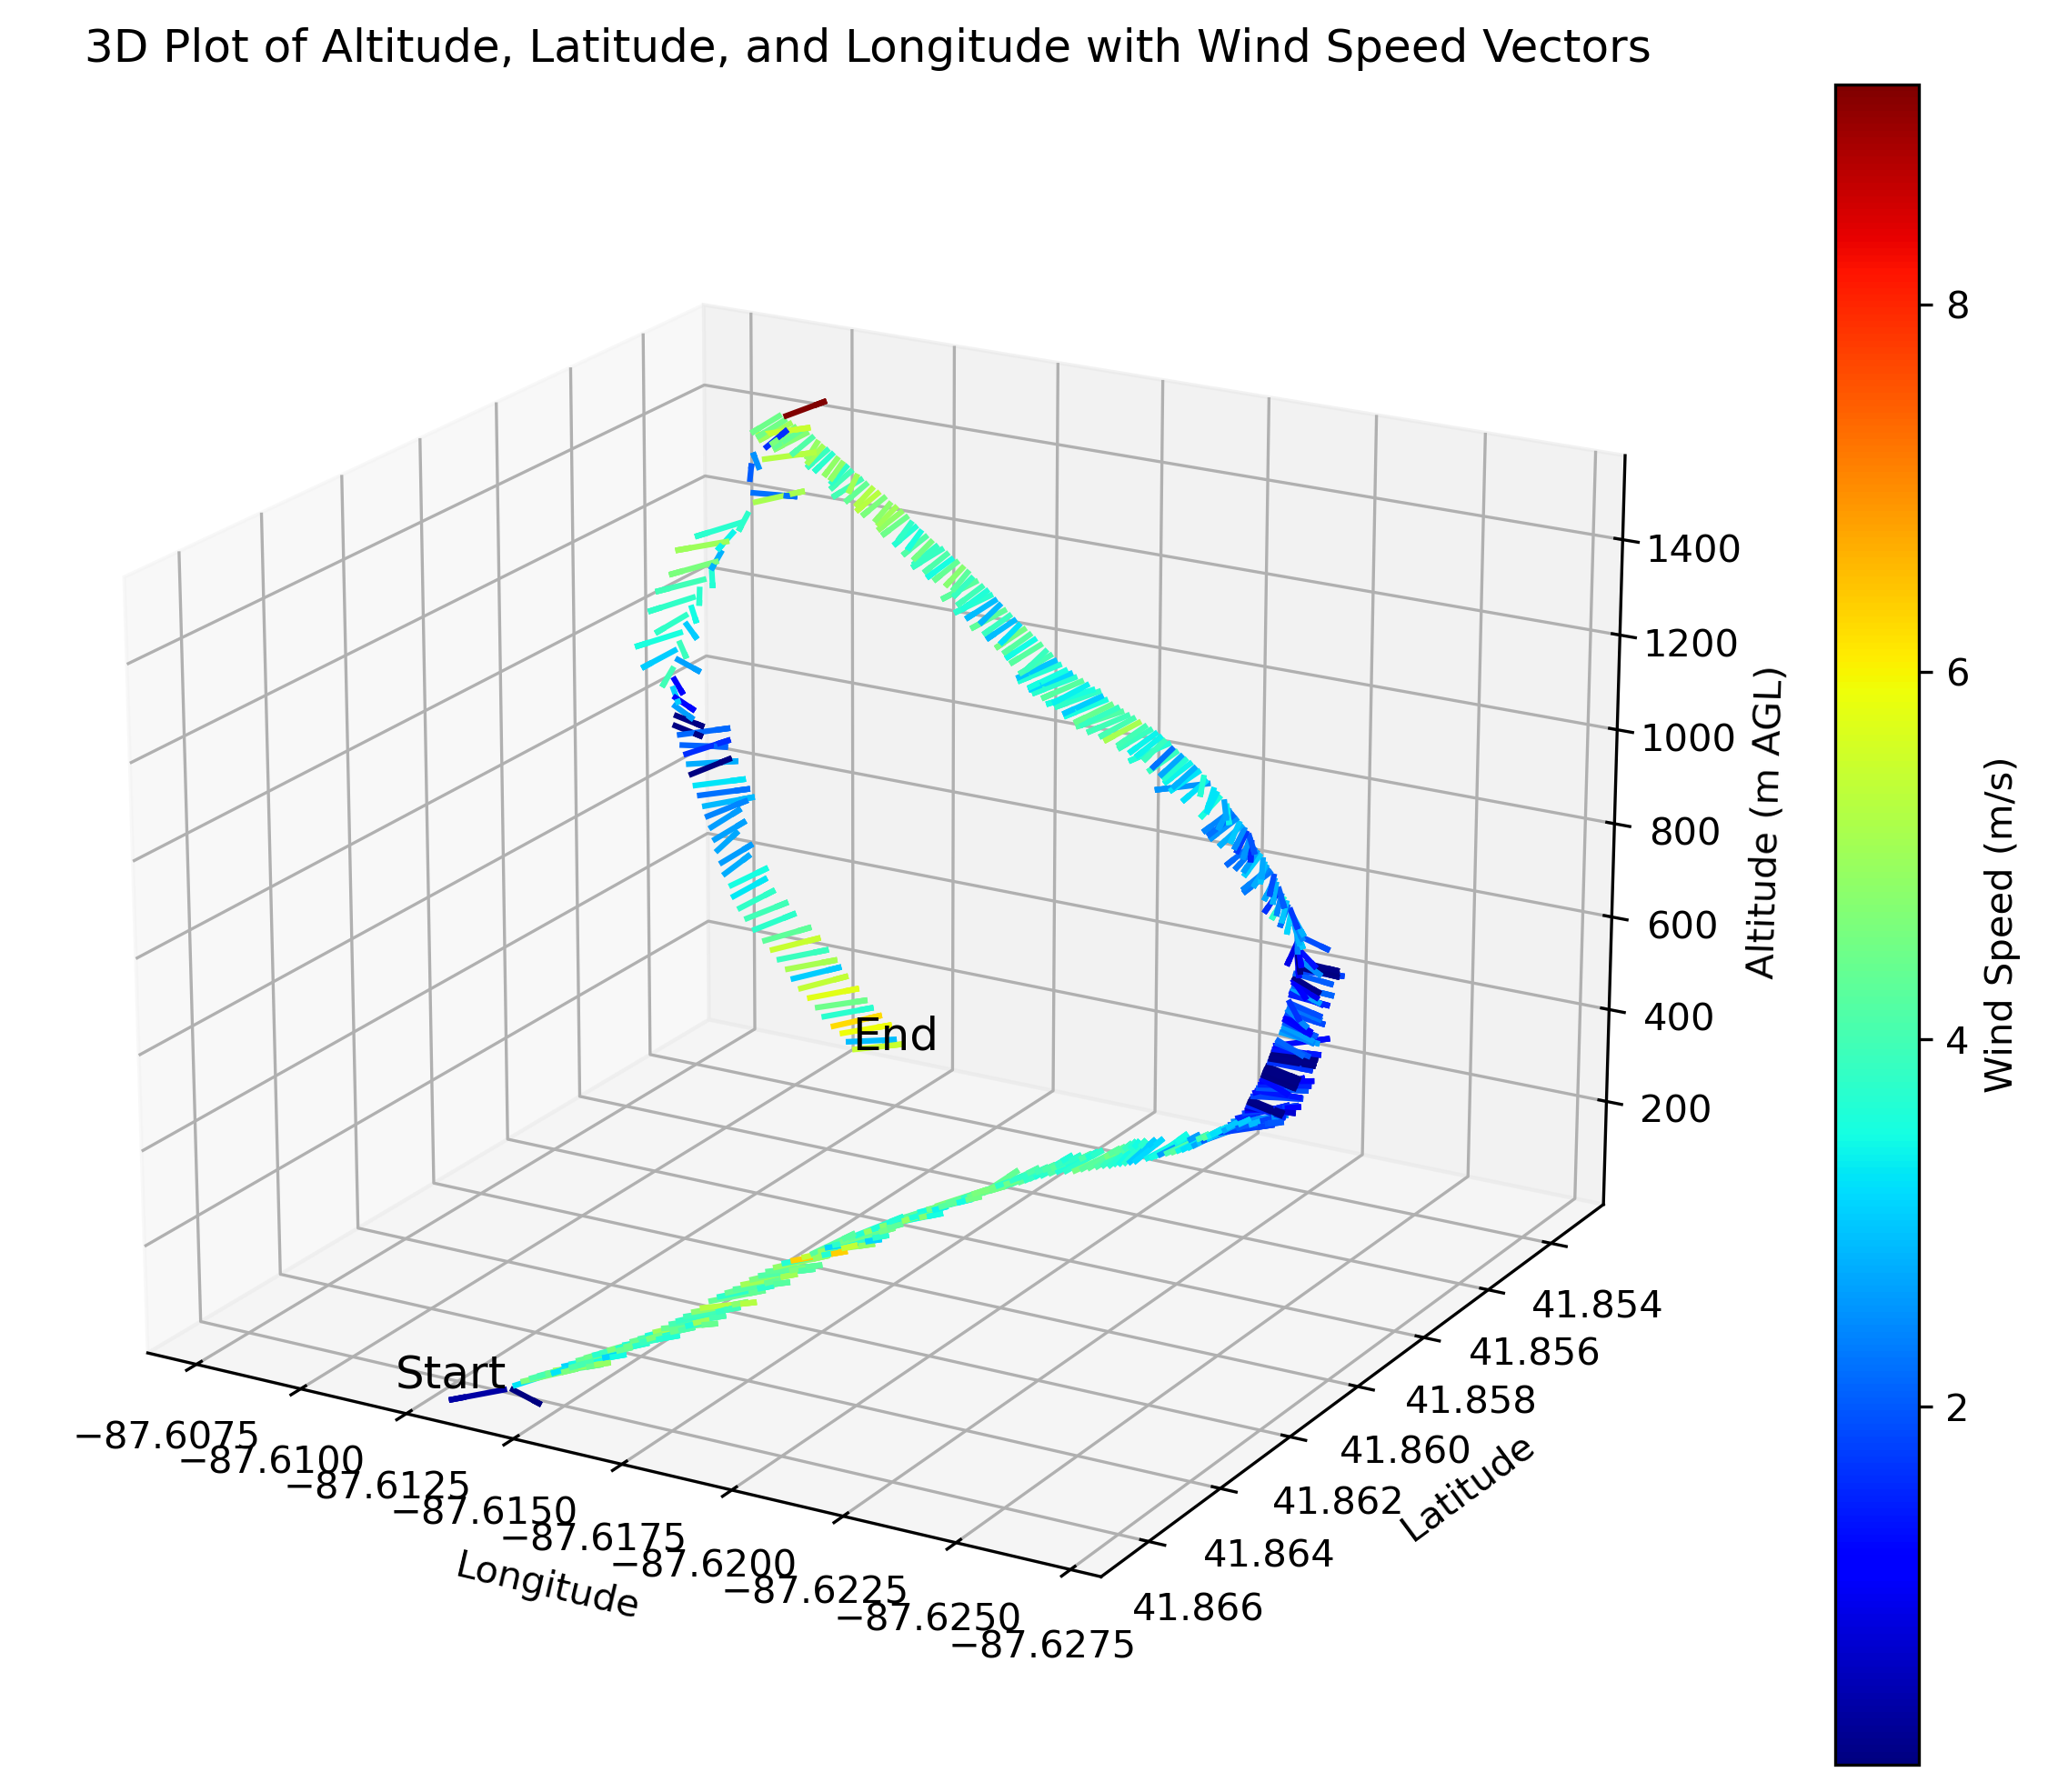

In [10]:
if not missing_lat_lon.empty and not non_missing_lat_lon.empty:
    # Interpolation function for wind speed
    speed_interp_func = interp1d(non_missing_lat_lon.index, non_missing_lat_lon['Speed (m/s)'], kind='linear', fill_value='extrapolate')
    
    # Apply the interpolation function to the indices of missing lat/lon rows
    data.loc[missing_lat_lon.index, 'Speed (m/s)'] = speed_interp_func(missing_lat_lon.index)

# Clean the data by removing rows with NaN values
cleaned_data = data.dropna(subset=['Latitude', 'Longitude', 'Altitude (m AGL)', 'Speed (m/s)', 'Heading (degrees)'])

# Verify the cleaned data
print(cleaned_data[['Latitude', 'Longitude', 'Altitude (m AGL)', 'Speed (m/s)', 'Heading (degrees)']].head())

# Convert heading to radians
cleaned_data = cleaned_data.copy()  # Avoid SettingWithCopyWarning
cleaned_data.loc[:, 'Heading (radians)'] = np.deg2rad(cleaned_data['Heading (degrees)'])

# Calculate the components of the wind vector
cleaned_data.loc[:, 'u'] = cleaned_data['Speed (m/s)'] * np.cos(cleaned_data['Heading (radians)'])
cleaned_data.loc[:, 'v'] = cleaned_data['Speed (m/s)'] * np.sin(cleaned_data['Heading (radians)'])
cleaned_data.loc[:, 'w'] = np.zeros_like(cleaned_data['u'])  # Assuming no vertical wind component for simplicity

# Create a 3D quiver plot with color coding for wind speed
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Normalize colors
norm = Normalize(vmin=cleaned_data['Speed (m/s)'].min(), vmax=cleaned_data['Speed (m/s)'].max())
colors = cm.jet(norm(cleaned_data['Speed (m/s)']))

# Plot the wind vectors
quiver = ax.quiver(cleaned_data['Longitude'], cleaned_data['Latitude'], cleaned_data['Altitude (m AGL)'],
                   cleaned_data['u'], cleaned_data['v'], cleaned_data['w'],
                   color=colors, length=0.001, normalize=True)

# Add start and end text
start_point = cleaned_data.iloc[0]
end_point = cleaned_data.iloc[-1]

ax.text(start_point['Longitude'], start_point['Latitude'], start_point['Altitude (m AGL)'], 'Start', color='black', fontsize=12, ha='right')
ax.text(end_point['Longitude'], end_point['Latitude'], end_point['Altitude (m AGL)'], 'End', color='black', fontsize=12, ha='left')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Wind Speed (m/s)')

# Add title and labels
plt.title('3D Plot of Altitude, Latitude, and Longitude with Wind Speed Vectors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Altitude (m AGL)')

# Set view to be from the x-axis straight on
ax.view_init(elev=20, azim=120)
plt.savefig('3Dwindsonde1431.png',dpi = 300, bbox_inches='tight')
# Display the plot
plt.show()